# DBSCAN Clustering
Phân cụm DBSCAN trên dữ liệu PCA30

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install scikit-learn kneed

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
import warnings
warnings.filterwarnings('ignore')

In [ ]:
DATA_PATH = "/content/drive/MyDrive/Project_ML/"

df_pca = pd.read_csv(DATA_PATH + 'data_pca30.csv', index_col=0)
X_pca30 = df_pca.values

print(f"Data shape: {X_pca30.shape}")

Data shape: (801, 30)


## Tìm eps tối ưu - k-distance plot

In [ ]:
k = 5
neigh = NearestNeighbors(n_neighbors=k)
neigh.fit(X_pca30)
distances, indices = neigh.kneighbors(X_pca30)
distances = np.sort(distances[:, k-1], axis=0)

knee = KneeLocator(range(len(distances)), distances,
                   curve='convex', direction='increasing')
eps_optimal = distances[knee.knee]

print(f"Optimal eps: {eps_optimal:.3f}")

Optimal eps: 111.017


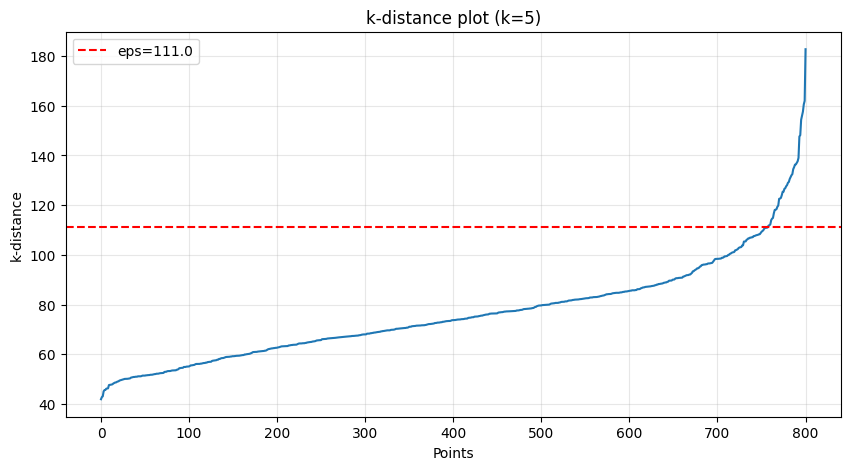

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.axhline(y=eps_optimal, color='red', linestyle='--', label=f'eps={eps_optimal:.1f}')
plt.xlabel('Points')
plt.ylabel('k-distance')
plt.title('k-distance plot (k=5)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Thuật toán DBSCAN tự xây dựng

In [ ]:
def Group1_DBSCAN(X, eps, min_samples):
    """DBSCAN tự xây dựng - Density-Based Spatial Clustering"""
    n = X.shape[0]
    labels = np.full(n, -1)
    visited = np.zeros(n, dtype=bool)
    cluster_id = 0

    def region_query(point_idx):
        distances = np.sqrt(np.sum((X - X[point_idx])**2, axis=1))
        return np.where(distances <= eps)[0]

    def expand_cluster(point_idx, neighbors):
        nonlocal cluster_id
        labels[point_idx] = cluster_id
        i = 0
        while i < len(neighbors):
            neighbor_idx = neighbors[i]
            if not visited[neighbor_idx]:
                visited[neighbor_idx] = True
                new_neighbors = region_query(neighbor_idx)
                if len(new_neighbors) >= min_samples:
                    neighbors = np.concatenate([neighbors, new_neighbors])
            if labels[neighbor_idx] == -1:
                labels[neighbor_idx] = cluster_id
            i += 1

    print("Running DBSCAN...")
    for point_idx in range(n):
        if point_idx % 100 == 0:
            print(f"  Processing {point_idx}/{n}")
        if visited[point_idx]:
            continue
        visited[point_idx] = True
        neighbors = region_query(point_idx)
        if len(neighbors) < min_samples:
            labels[point_idx] = -1
        else:
            expand_cluster(point_idx, neighbors)
            cluster_id += 1

    print(f"Done! Found {cluster_id} clusters.")
    return labels

## Train DBSCAN với eps tối ưu

In [ ]:
# Gọi DBSCAN tự code
labels_dbscan = Group1_DBSCAN(X_pca30, eps=eps_optimal, min_samples=5)

# Tính toán metrics
n_clusters = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise = list(labels_dbscan).count(-1)
sil_dbscan = silhouette_score(X_pca30, labels_dbscan) if n_clusters > 1 else 0

print(f"\nDBSCAN Results:")
print(f"  eps = {eps_optimal:.3f}")
print(f"  min_samples = 5")
print(f"  Clusters = {n_clusters}")
print(f"  Noise points = {n_noise}")
print(f"  Silhouette Score = {sil_dbscan:.4f}")

print(f"\nPhân bố mẫu:")
unique, counts = np.unique(labels_dbscan, return_counts=True)
for cluster, count in zip(unique, counts):
    name = 'Noise' if cluster == -1 else f'Cluster {cluster}'
    print(f"  {name}: {count} samples")

Running DBSCAN...
  Processing 0/801
  Processing 100/801
  Processing 200/801
  Processing 300/801
  Processing 400/801
  Processing 500/801
  Processing 600/801
  Processing 700/801
  Processing 800/801
Done! Found 5 clusters.

DBSCAN Results:
  eps = 111.017
  min_samples = 5
  Clusters = 5
  Noise points = 25
  Silhouette Score = 0.3663

Phân bố mẫu:
  Noise: 25 samples
  Cluster 0: 135 samples
  Cluster 1: 129 samples
  Cluster 2: 295 samples
  Cluster 3: 140 samples
  Cluster 4: 77 samples


## Lưu kết quả

In [ ]:
df_labels = pd.DataFrame(labels_dbscan, index=df_pca.index, columns=['dbscan'])
df_labels.to_csv(DATA_PATH + 'dbscan_labels.csv')
print("Saved: dbscan_labels.csv")

Saved: dbscan_labels.csv


## Visualization

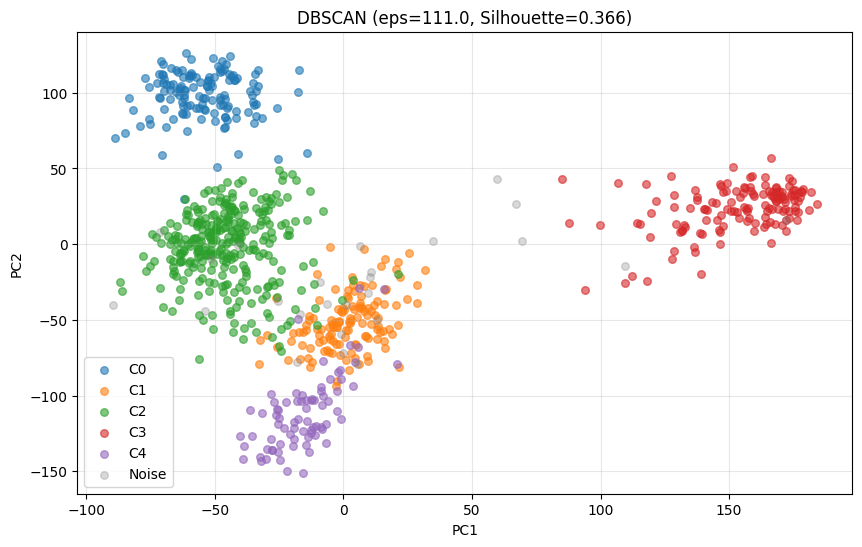

In [ ]:
plt.figure(figsize=(10, 6))
unique_labels = set(labels_dbscan)
for k in unique_labels:
    if k == -1:
        col = 'gray'
        label = 'Noise'
        alpha = 0.3
    else:
        col = None
        label = f'C{k}'
        alpha = 0.6
    class_member_mask = (labels_dbscan == k)
    plt.scatter(X_pca30[class_member_mask, 0], X_pca30[class_member_mask, 1],
                c=col, label=label, alpha=alpha, s=30)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title(f'DBSCAN (eps={eps_optimal:.1f}, Silhouette={sil_dbscan:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Đánh giá ARI và NMI với nhãn thực tế

In [ ]:
# Load nhãn thực tế từ file labels.csv
df_true_labels = pd.read_csv(DATA_PATH + 'labels.csv', index_col=0)
y_true = df_true_labels.values.ravel()

print(f"True labels shape: {y_true.shape}")
print(f"Predicted labels shape: {labels_dbscan.shape}")
print(f"Number of true classes: {len(np.unique(y_true))}")
print(f"Number of predicted clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")

True labels shape: (801,)
Predicted labels shape: (801,)
Number of true classes: 5
Number of predicted clusters: 5
Number of noise points: 25


In [ ]:
# Tính ARI và NMI
ari_score = adjusted_rand_score(y_true, labels_dbscan)
nmi_score = normalized_mutual_info_score(y_true, labels_dbscan)

print("\n" + "="*60)
print("ĐÁNH GIÁ DBSCAN SO VỚI NHÃN THỰC TẾ")
print("="*60)
print(f"Adjusted Rand Index (ARI):        {ari_score:.4f}")
print(f"Normalized Mutual Info (NMI):     {nmi_score:.4f}")
print(f"Silhouette Score:                 {sil_dbscan:.4f}")
print("="*60)

print("\n📊 Giải thích:")
print("  ARI (Adjusted Rand Index):")
print("    • 1.0  : Phân cụm hoàn hảo (giống 100% với nhãn thực)")
print("    • 0.0  : Phân cụm ngẫu nhiên")
print("    • < 0  : Phân cụm tệ hơn ngẫu nhiên")
print("")
print("  NMI (Normalized Mutual Information):")
print("    • 1.0  : Phân cụm hoàn hảo")
print("    • 0.0  : Không có thông tin chung giữa hai phân hoạch")
print("    • 0.5+ : Có sự tương đồng đáng kể")


ĐÁNH GIÁ DBSCAN SO VỚI NHÃN THỰC TẾ
Adjusted Rand Index (ARI):        0.9577
Normalized Mutual Info (NMI):     0.9400
Silhouette Score:                 0.3663

📊 Giải thích:
  ARI (Adjusted Rand Index):
    • 1.0  : Phân cụm hoàn hảo (giống 100% với nhãn thực)
    • 0.0  : Phân cụm ngẫu nhiên
    • < 0  : Phân cụm tệ hơn ngẫu nhiên

  NMI (Normalized Mutual Information):
    • 1.0  : Phân cụm hoàn hảo
    • 0.0  : Không có thông tin chung giữa hai phân hoạch
    • 0.5+ : Có sự tương đồng đáng kể
